<a href="https://www.kaggle.com/code/mohdmuttalib/english-language-learning?scriptVersionId=182510534" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from lightgbm import LGBMRegressor
from sklearn import model_selection
from sklearn import metrics

In [2]:
train = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
ss = pd.read_csv('../input/feedback-prize-english-language-learning/sample_submission.csv')

In [3]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


EDA

Check distributions

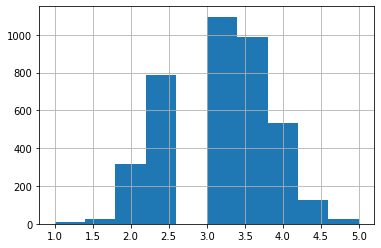

In [4]:
train.cohesion.hist();

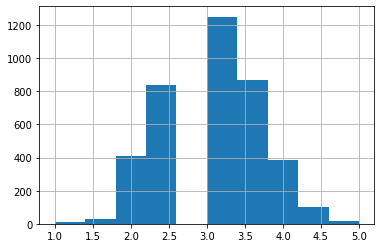

In [5]:
train.syntax.hist();

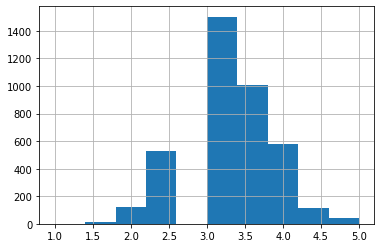

In [6]:
train.vocabulary.hist();

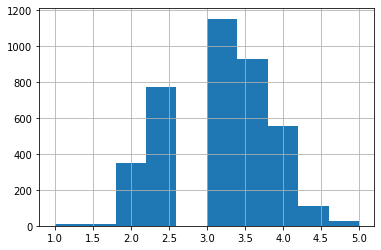

In [7]:
train.phraseology.hist();

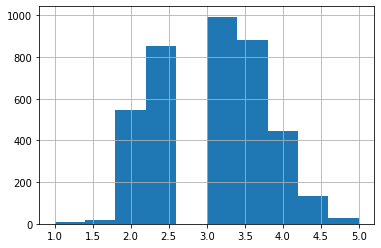

In [8]:
train.grammar.hist();

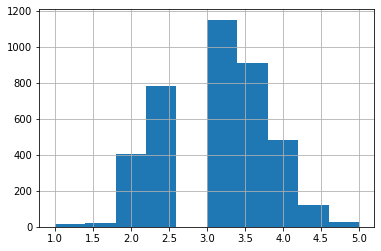

In [9]:
train.conventions.hist();

In [10]:
# check length of content
def get_length_of_text(x):
    return len(x)

print(f'Average length: {train.full_text.apply(lambda x: get_length_of_text(x)).mean():0.2f}')
print(f'Std length: {train.full_text.apply(lambda x: get_length_of_text(x)).std():0.2f}')
print(f'Min length: {train.full_text.apply(lambda x: get_length_of_text(x)).min():0.2f}')
print(f'Max length: {train.full_text.apply(lambda x: get_length_of_text(x)).max():0.2f}')

Average length: 2334.52
Std length: 1033.41
Min length: 82.00
Max length: 6044.00


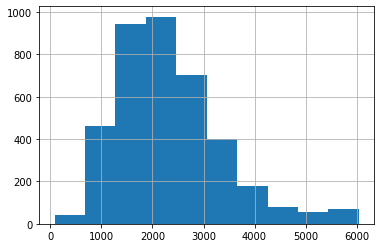

In [11]:
train.full_text.apply(lambda x: get_length_of_text(x)).hist();

First question: why is there no value between 2.5 and 3 for any of the variables?


Check nans


In [12]:
train.isna().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

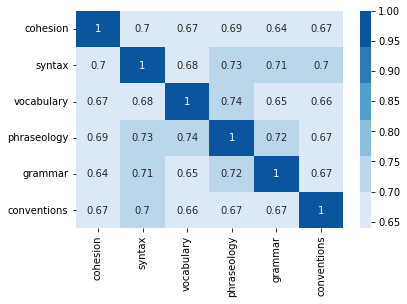

In [13]:
colormap = sns.color_palette("Blues")
sns.heatmap(train.corr(), annot=True, cmap=colormap);

All variables are kinda correlated with each other


Modeling

The idea here is to predict all variables.

Two approaches:

Multioutput regression
Single output regression x6

In [14]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [15]:
df = train.copy()
# we are going to iterate through each target variable
target_vars = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [16]:
# we need to extract the vectors from the text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, max_features=5000) # this should be tuned in the future
vectorizer.fit(raw_documents=train.full_text)

TfidfVectorizer(max_features=5000, sublinear_tf=True)

In [17]:
def extract_vectors(x):
    vecs = vectorizer.transform(x)
    return vecs.toarray().flatten()

# extract_vectors([train.iloc[0].full_text])
df['vecs'] = train.full_text.apply(lambda x: extract_vectors([x]))

In [18]:
df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,vecs
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
feature_set = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    vecs = row['vecs']
    vals = row[target_vars].astype(float)
    features = np.hstack([vecs, vals]).flatten()
    feature_set.append(features)
feature_set = np.array(feature_set)

100%|██████████| 3911/3911 [00:02<00:00, 1356.13it/s]


In [20]:
cohesion_train = feature_set[:, -6]
syntax_train = feature_set[:, -5]
vocabulary_train = feature_set[:, -4]
phraseology_train = feature_set[:, -3]
grammar_train = feature_set[:, -2]
conventions_train = feature_set[:, -1]

X = feature_set[:, :-6]

In [21]:
n_estimators = 200
max_depth = 5
learning_rate = 0.1

cohesion_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
syntax_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
vocabulary_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
phraseology_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
grammar_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
conventions_model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

In [22]:
performances_container = []

In [23]:
# cross-validation loop - cohesion
cv_strategy = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

performances = {}

for var in [("cohesion", cohesion_train), ("syntax", syntax_train), ("vocabulary", vocabulary_train), 
            ("phraseology", phraseology_train), ("grammar", grammar_train), ("conventions", conventions_train)]:
    print(f'Validating on {var[0]}')
    fold = 0
    train_scores = []
    val_scores = []
    
    n_estimators = 200
    max_depth = 5
    learning_rate = 0.1
    
    for train_idx, val_idx in cv_strategy.split(X, var[1]):

        # train
        X_train = X[train_idx]
        y_train = var[1][train_idx]

        # validation
        X_val = X[val_idx]
        y_val = var[1][val_idx]

        # ~~~~~APPLY LOGIC~~~~~

        # ~~~~~~~~~~~~~~~~~~~~~

        # training
        model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        model.fit(X_train, y_train)

        # predicting
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        # storing scores
        train_score = np.sqrt(metrics.mean_squared_error(y_train, train_preds))
        val_score = np.sqrt(metrics.mean_squared_error(y_val, val_preds))

        train_scores.append(train_score)
        val_scores.append(val_score)

        print(f"Fold {fold} ==> Train accuracy: {train_score:0.4f} | Validation accuracy: {val_score:0.4f}")
        fold += 1

    training_performance = np.mean(train_scores)
    val_performance = np.mean(val_scores)
    performances = {"var": var[0], "training_performance": training_performance, "val_performance": val_performance, "n_estimators": n_estimators, "max_depth": max_depth, "learning_rate": learning_rate}
    performances_container.append(performances)
    print(f"END. Training performance: {training_performance:0.4f} | Validation performance: {val_performance:0.4f}\n")

Validating on cohesion
Fold 0 ==> Train accuracy: 0.2811 | Validation accuracy: 0.5536
Fold 1 ==> Train accuracy: 0.2988 | Validation accuracy: 0.5705
Fold 2 ==> Train accuracy: 0.2936 | Validation accuracy: 0.5482
Fold 3 ==> Train accuracy: 0.2907 | Validation accuracy: 0.5804
Fold 4 ==> Train accuracy: 0.2857 | Validation accuracy: 0.5623
END. Training performance: 0.2899 | Validation performance: 0.5630

Validating on syntax
Fold 0 ==> Train accuracy: 0.2737 | Validation accuracy: 0.5590
Fold 1 ==> Train accuracy: 0.2873 | Validation accuracy: 0.5516
Fold 2 ==> Train accuracy: 0.2754 | Validation accuracy: 0.5451
Fold 3 ==> Train accuracy: 0.2795 | Validation accuracy: 0.5453
Fold 4 ==> Train accuracy: 0.2876 | Validation accuracy: 0.5277
END. Training performance: 0.2807 | Validation performance: 0.5458

Validating on vocabulary
Fold 0 ==> Train accuracy: 0.2450 | Validation accuracy: 0.4878
Fold 1 ==> Train accuracy: 0.2542 | Validation accuracy: 0.4976
Fold 2 ==> Train accuracy: 

In [24]:
cohesion_model.fit(X, cohesion_train)
syntax_model.fit(X, syntax_train)
vocabulary_model.fit(X, vocabulary_train)
phraseology_model.fit(X, phraseology_train)
grammar_model.fit(X, grammar_train)
conventions_model.fit(X, conventions_train)

LGBMRegressor(max_depth=5, n_estimators=200)

In [25]:
_test = test.copy()
_test['vecs'] = _test.full_text.apply(lambda x: extract_vectors([x]))

In [26]:
test_feature_set = []
for i, row in tqdm(_test.iterrows(), total=len(_test)):
    test_feature_set.append(row.vecs)
test_feature_set = np.array(test_feature_set)

100%|██████████| 3/3 [00:00<00:00, 1547.33it/s]


In [27]:
cohesion_predictions = cohesion_model.predict(test_feature_set)
syntax_predictions = syntax_model.predict(test_feature_set)
vocabulary_predictions = vocabulary_model.predict(test_feature_set)
phraseology_predictions = phraseology_model.predict(test_feature_set)
grammar_predictions = grammar_model.predict(test_feature_set)
conventions_predictions = conventions_model.predict(test_feature_set)

In [28]:
submission = ss.copy()
submission.cohesion = cohesion_predictions
submission.syntax = syntax_predictions
submission.vocabulary = vocabulary_predictions
submission.phraseology = phraseology_predictions
submission.grammar = grammar_predictions
submission.conventions = conventions_predictions

In [29]:
submission.to_csv("submission.csv", index=False)